<h1> Custom Environment </h1>
<h4> -An attempt at creating it from scratch </h4>
<i> "You either die a hero, or live long enough to see yourself become a villain."</i>

class
<br>
initializer
<br>
step
<br>
reset
<br>
render
<br>
close
<br>
<br>
Validate thorugh check_env()

https://colab.research.google.com/github/araffin/rl-tutorial-jnrr19/blob/master/5_custom_gym_env.ipynb#scrollTo=9DOpP_B0-LXm

In [1]:
import numpy as np
import pandas as pd

import gymnasium as gym
from gymnasium import spaces

from stable_baselines3.common.env_checker import check_env

from stable_baselines3 import SAC
from stable_baselines3 import PPO
#from stable_baselines3 import RecurrentPPO

In [33]:
history_usage = 80


return_data = pd.read_csv("../../Data/StockReturns.csv")

esg_data = np.array([36.6, 35.3, 17.9, 18, 
                    18, 21.2, 18.7, 29.2, 
                    15.7, 25.6, 25.6, 18.4, 
                    19.8, 13.8, 18.1, 19, 
                    17.2, 14, 17.2, 19.5, 
                    19.7, 21.2, 26.8, 19.3])

objective = "Sharpe"

esg_compliancy = True

In [32]:
split_size = 0.85

train_data = return_data.iloc[:int(split_size*len(return_data))]
test_data = return_data.iloc[int(split_size*len(return_data)):].reset_index(drop=True)

In [ ]:
class PortfolioEnvironment(gym.Env):
    """
    doc string
    """
    def __init__(self,
                 history_usage,
                 return_data, esg_data,
                 objective, esg_compliancy):
        super().__init__()
        """
        doc  string,

        Good, initialize all variables with values 
        """
        self.return_data = return_data.values
        self.esg_data: np.array = esg_data
        self.history_usage: int = history_usage
        self.n_stocks = len(esg_data)

        self.objective: str = objective
        self.esg_compliancy: bool = esg_compliancy

        self.action_space = spaces.Box(low=-1, 
                                       high=1, 
                                       shape=(self.n_stocks,),)
        self.observation_space = spaces.Box(low=-np.inf, 
                                            high=np.inf, 
                                            shape=(self.n_stocks * self.history_usage,))

        self.current_step: int = 0
        self.weights_list: list = []
        self.returns_list: list = []
        


    def reset(self, seed=42):
        """
        doc string

        Good, changing all non-fixed variables inside the environment
        """
        super().reset(seed=None)

        self.current_step = 0
        self.weights = []
        self.portfolio_returns = []

        observation = self.get_observation()
        additional_info = {
            "time_step": self.current_step,
            "cumulative_geo_return": np.cumprod(self.portfolio_returns)
        }

        return observation, additional_info



    def get_observation(self):
        """
        doc string
        """
        start_idx = max(0, self.current_step -self.history_usage)
        end_idx = self.current_step
        observation_space  = self.return_data[start_idx:end_idx].T
        if observation_space.shape[1] < self.history_usage:
            padding = np.zeros((self.n_stocks, self.history_usage - observation_space.shape[1]))
            observation_space = np.hstack([padding, observation_space])
        
        return observation_space.flatten().astype(np.float32)


    def step(self, action):
        """
        doc string
        """
        # Generate weights based on actions
        # Forces action from in range (-1,1) to become (0,1)
        if self.current_step == 0:
            current_weights = self.weights
        else:
            current_weights = action
        self.weights_list.append(current_weights)
        
        # Find current weights and multiply with weights
        # Variables for (early) stopping
        terminated = self.current_step >= len(self.return_data)-1
        truncated = False
        if not terminated:
            current_returns = self.return_data[self.current_step +1]
            portfolio_return = 0.0
            if self.current_step +1 < len(self.return_data):
                portfolio_return = np.dot(current_weights, current_returns)
            self.returns_list.append(portfolio_return)
        else:
            portfolio_return = 0.0
            self.returns_list.append(portfolio_return)
        # New step
        self.current_step += 1

        # if terminated:
            

        # Returns the next observation space for the algo to use
        next_window = self.get_observation()

        return next_window, portfolio_return, terminated, truncated, {}
        


    def render(self, mode="human"):
        """ 
        doc string
        """
        print(f"Current step: {self.current_step}, and geometric return: {np.cumprod(self.portfolio_returns)}")
        pass

In [5]:
train_env = PortfolioEnvironment(history_usage=history_usage, 
                              return_data=train_data,
                              esg_data=esg_data,
                              objective=objective,
                              esg_compliancy=esg_compliancy)
check_env(train_env, warn=True)

In [27]:
model = SAC(policy="MlpPolicy",
            gamma=0.95,
            batch_size=256,
            ent_coef=0.1,
            env=train_env,
            buffer_size=100_000,
            gradient_steps= 64,
            train_freq=(64, 'step'),
            verbose=1
            ).learn(3000)

Using cpu device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.


c:\Programmering\jakob\.venv\Lib\site-packages\stable_baselines3\common\buffers.py:242: UserWarning: This system does not have apparently enough memory to store the complete replay buffer 2.31GB > 2.26GB
  warnings.warn(


In [19]:
test_env = PortfolioEnvironment(history_usage=history_usage, 
                              return_data=test_data,
                              esg_data=esg_data,
                              objective=objective,
                              esg_compliancy=esg_compliancy)

In [8]:
# Train weights

obs, info = train_env.reset()
weights_history_t = []
finished = False

while not finished: 
    action, _ = model.predict(obs, deterministic=True)

    weights_t = (action+1) / 2
    weights_t /= np.sum(weights_t)

    obs, reward, terminated, truncated, info = train_env.step(action)
    finished = terminated or truncated

    weights_history_t.append(weights_t)

In [28]:
obs, info = test_env.reset()
weights_history = []
finished = False

while not finished: 
    action, _ = model.predict(obs, deterministic=True)

    weights = (action+1) / 2
    weights /= np.sum(weights)

    obs, reward, terminated, truncated, info = test_env.step(action)
    finished = terminated or truncated

    weights_history.append(weights)

In [29]:
df = pd.DataFrame(weights_history)
df_t = pd.DataFrame(weights_history_t)

In [11]:
df

,0,1,2,3,4,5,6,7,8,9,...,14,15,16,17,18,19,20,21,22,23
0,0.038888,0.050386,0.046203,0.043480,0.043033,0.044510,0.037672,0.043021,0.042699,0.043676,...,0.050622,0.027493,0.037100,0.045756,0.050277,0.035027,0.034017,0.041453,0.044482,0.044060
1,0.038705,0.050409,0.046542,0.043579,0.043229,0.044439,0.037464,0.042888,0.042691,0.043408,...,0.050702,0.027519,0.037253,0.045888,0.050112,0.034983,0.033879,0.041545,0.044482,0.044131
2,0.038837,0.050224,0.046942,0.043484,0.043019,0.044286,0.037780,0.042311,0.042463,0.044121,...,0.050570,0.027296,0.037889,0.045975,0.050324,0.035093,0.033521,0.041935,0.044477,0.043981
3,0.038559,0.050334,0.047060,0.043605,0.043413,0.044507,0.037599,0.042658,0.042556,0.043471,...,0.050674,0.027441,0.037675,0.046065,0.049977,0.034944,0.033500,0.041917,0.044417,0.044127
4,0.038974,0.050450,0.047620,0.043150,0.043620,0.044168,0.037566,0.041989,0.042127,0.043988,...,0.050147,0.027473,0.038261,0.046371,0.050514,0.035041,0.033327,0.041586,0.044567,0.044182
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1200,0.040559,0.050194,0.046759,0.042441,0.044421,0.044980,0.037471,0.043436,0.042574,0.041918,...,0.047802,0.029347,0.035129,0.046806,0.050307,0.035240,0.035394,0.038905,0.045038,0.045286
1201,0.039469,0.050072,0.046525,0.044782,0.043567,0.042374,0.035780,0.041226,0.042353,0.044745,...,0.049322,0.028522,0.038516,0.045259,0.051014,0.036165,0.034726,0.040181,0.045546,0.043579
1202,0.039163,0.050417,0.047338,0.041720,0.043743,0.044489,0.037350,0.041994,0.043940,0.045296,...,0.047505,0.028901,0.036778,0.044441,0.050783,0.035897,0.034035,0.040142,0.045518,0.043831
1203,0.037984,0.049237,0.048685,0.044287,0.041588,0.042516,0.037611,0.039428,0.042874,0.046536,...,0.050648,0.026685,0.040983,0.046150,0.050649,0.035476,0.031651,0.044108,0.045016,0.043314


In [12]:
from stable_baselines3.common.evaluation import evaluate_policy

In [24]:
mean_reward, std_reward = evaluate_policy(model, train_env, n_eval_episodes=10)
print(f"mean_reward:{mean_reward:.2f} +/- {std_reward:.2f}")

c:\Programmering\jakob\.venv\Lib\site-packages\stable_baselines3\common\evaluation.py:67: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


mean_reward:2.19 +/- 0.00


In [25]:
mean_reward, std_reward = evaluate_policy(model, test_env, n_eval_episodes=10)
print(f"mean_reward:{mean_reward:.2f} +/- {std_reward:.2f}")

mean_reward:0.21 +/- 0.00


In [30]:
df.to_csv("..\..\Data\RL_weights_test.csv", index=False)
df_t.to_csv("..\..\Data\RL_weights_train.csv", index=False)

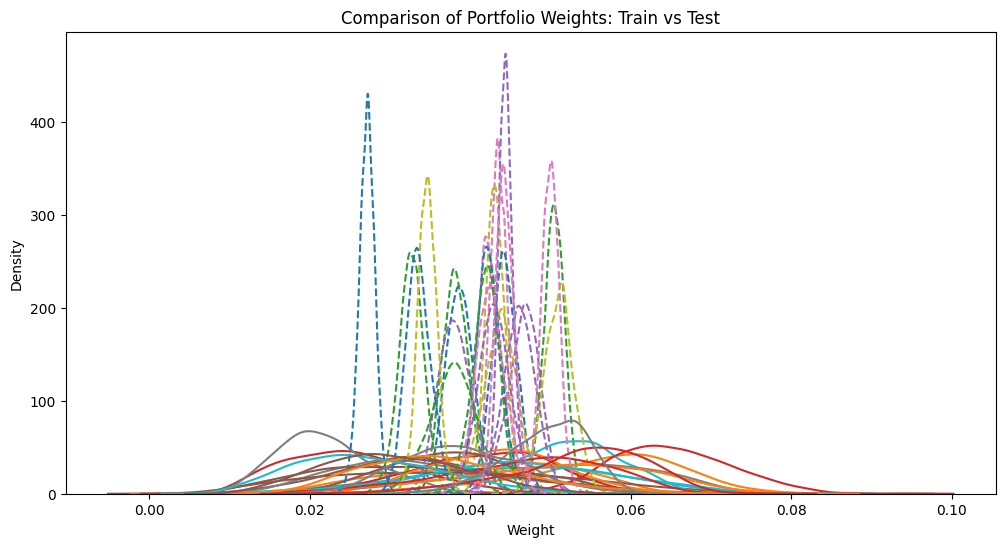

In [31]:
import seaborn as sns
import matplotlib.pyplot as plt

train_weights = np.array(weights_history_t)
test_weights = np.array(weights_history)

# Plot distributions
plt.figure(figsize=(12,6))
for i in range(train_weights.shape[1]):  # Iterate over assets
    sns.kdeplot(train_weights[:, i], label=f"Train Asset {i+1}", linestyle="--")
    sns.kdeplot(test_weights[:, i], label=f"Test Asset {i+1}")
    

plt.title("Comparison of Portfolio Weights: Train vs Test")
plt.xlabel("Weight")
plt.ylabel("Density")
plt.show()

In [17]:
def evaluate_performance(env, model):
    obs, _ = env.reset()
    portfolio_returns = []
    done = False
    
    while not done:
        action, _ = model.predict(obs, deterministic=True)
        weights = (action + 1) / 2
        weights = (weights+1e-8) / (np.sum(weights)+1e-8)
        obs, reward, terminated, truncated, _ = env.step(weights)
        done = terminated or truncated
        portfolio_returns.append(reward)  # Store reward (assumed portfolio return)

    return np.array(portfolio_returns)

# Compute cumulative returns
train_returns = evaluate_performance(train_env, model)
test_returns = evaluate_performance(test_env, model)

plt.figure(figsize=(12,6))
#plt.plot(np.cumprod(train_returns+1), label="Train", linestyle="--")
plt.plot(np.linspace(4818,4818+1204,1204), np.cumprod(train_returns+1)[-1]* bravo, label="bravo")
plt.plot(np.linspace(4818,4818+1205,1205), np.cumprod(train_returns+1)[-1] * np.cumprod(test_returns+1), label="Test")
plt.legend()
plt.title("Cumulative Returns: Train vs Test")
plt.xlabel("Time Step")
plt.ylabel("Cumulative Return")
plt.show()


NameError: name 'bravo' is not defined

<Figure size 1200x600 with 0 Axes>

In [ ]:
len(train_returns)

4817

In [ ]:
df

,0,1,2,3,4,5,6,7,8,9,...,14,15,16,17,18,19,20,21,22,23
0,0.039542,0.055493,0.045642,0.026046,0.037876,0.032996,0.057739,0.040476,0.042772,0.038652,...,0.043922,0.029623,0.031985,0.042044,0.054810,0.036994,0.030449,0.039620,0.047324,0.031681
1,0.048437,0.057145,0.049120,0.023168,0.033813,0.029529,0.055594,0.045000,0.042770,0.034769,...,0.045457,0.032013,0.032808,0.047514,0.054743,0.035046,0.030025,0.033827,0.046474,0.025820
2,0.041512,0.059475,0.053507,0.023124,0.039446,0.029028,0.061085,0.041441,0.041408,0.035709,...,0.049319,0.032193,0.033368,0.044567,0.052021,0.041221,0.027986,0.034327,0.043726,0.021686
3,0.043088,0.061235,0.055616,0.022456,0.037464,0.027295,0.061672,0.040872,0.041252,0.034657,...,0.050490,0.032801,0.034497,0.045822,0.051880,0.041771,0.027825,0.032119,0.043076,0.019238
4,0.044868,0.061098,0.051933,0.023834,0.035546,0.026884,0.057745,0.040511,0.041047,0.033591,...,0.046052,0.030745,0.033883,0.045858,0.055233,0.039920,0.028847,0.036026,0.045127,0.023812
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1200,0.037635,0.052129,0.038173,0.025105,0.041702,0.037517,0.057144,0.044402,0.042885,0.047877,...,0.035809,0.022137,0.025437,0.045058,0.062362,0.028173,0.026788,0.044391,0.050931,0.032470
1201,0.060978,0.021568,0.012468,0.010228,0.063563,0.061258,0.070781,0.044048,0.059603,0.056520,...,0.065459,0.036340,0.028747,0.029490,0.022194,0.039350,0.050310,0.046249,0.053016,0.055507
1202,0.059468,0.062399,0.046554,0.028484,0.022203,0.016852,0.023470,0.065421,0.036404,0.016495,...,0.032635,0.024489,0.020750,0.057553,0.063488,0.029323,0.036192,0.027391,0.060728,0.037154
1203,0.070574,0.055655,0.044056,0.012558,0.030078,0.029118,0.056969,0.054269,0.047085,0.031828,...,0.058442,0.037275,0.035435,0.055263,0.041171,0.034845,0.037634,0.023128,0.050658,0.018770


In [ ]:
start_idx = 4818

aligned_returns = return_data.iloc[start_idx:start_idx + len(df)].values
vekter = df.values[:-1] 

portfolio_returns = np.sum(vekter * aligned_returns, axis=1)

portfolio_returns_df = pd.DataFrame(portfolio_returns, columns=["Portfolio_Returns"])

print(portfolio_returns_df.head())

   Portfolio_Returns
0           0.006086
1           0.006929
2           0.000378
3           0.008019
4           0.005863


In [ ]:
len(portfolio_returns_df)

1204

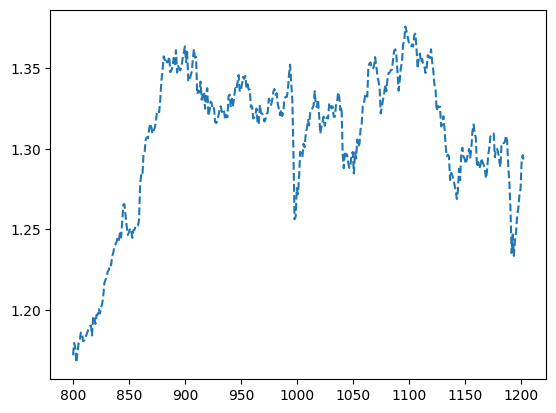

In [ ]:
plt.plot(np.cumprod(portfolio_returns_df+1)[800:], label="Train", linestyle="--")

In [ ]:
bravo = np.cumprod(portfolio_returns_df+1)

In [ ]:
len(bravo)

1204

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import importlib.util
import os

module_name = "MencheroOGA"
module_path = os.path.abspath("../Result/Menchero_OGA.py")

spec = importlib.util.spec_from_file_location(module_name, module_path)
my_module = importlib.util.module_from_spec(spec)
spec.loader.exec_module(my_module)




class GenerateResult():

    def __init__(self, path, n_sectors, n_stock_per_sector, n_optimizations, esg_data, sector_names):    
        self.returns = pd.read_csv("Data/StockReturns.csv")
        self.bench_w = pd.read_csv("Data/MPT_weights.csv")
        self.path = path
        self.exper_w = pd.read_csv("Data/RL_weights_"+self.path+".csv")
        self.esg_data = esg_data

        self.n_sectors = n_sectors
        self.n_stock = n_stock_per_sector
        # All optimizations weights are to be multiplied with returns for time t+1
        self.n_optimizations = n_optimizations - 1
        self.sector_names = sector_names
        

        self.exper_analysis: dict = None

    
    def store_values(self,i,pa,ps,ar,er,br,esg):
        mydict = {"sector_allocation":pa,
                "sector_selection":ps,
                "active_return": ar,
                "return":er,
                "bench_return":br,
                "esg_score":esg,
                }
        self.exper_analysis = mydict
    


    def plot_values(self,algo_name, pa, ps, ar, er,br,esg):
        pap = [np.prod(pa[i]+1) for i in range(len(pa))]
        psp = [np.prod(ps[i]+1) for i in range(len(ps))]

        bigfig, ax = plt.subplots(3,2,figsize=(10,10))
        ax[0,0].plot(br, color="grey", label="Benchmark")
        ax[0,0].plot(er, color="blue", label="Experimental")
        ax[0,0].plot(ar, color="green", label= "Geometric active return")
        ax[0,0].scatter(x=np.linspace(0,self.n_optimizations-1, self.n_optimizations), y =(br*ar), 
                s=5, color="black", label="Validity Control")
        ax[0,0].set_ylabel("Return")
        ax[0,0].set_xlabel("Trading times")
        ax[0,0].set_title('General Portfolio Performance')
        ax[0,0].legend()

        # ax[0,1].plot(er, color="blue", label="Experimental")
        # ax[0,1].scatter(x=np.linspace(0,self.n_optimizations-1,self.n_optimizations), y =(br*ar), 
        #                 s=5, color="black", label="Validity Control")
        # ax[0,1].set_ylabel("Return")
        # ax[0,1].set_xlabel("Trading times")
        # ax[0,1].set_title('Benchmark * Active return')
        # ax[0,1].legend()
    
        data_arrays = [pap, psp]
        data_labels = ["Allocation", "Selection"]
        ax[0,1].boxplot(data_arrays, tick_labels=data_labels)
        ax[0,1].axhline(y=1, color="black")
        ax[0,1].set_ylabel("Return")
        ax[0,1].set_title('Attribution Effect Variation')

        ax[1,0].scatter(x=esg, y=er,
                        s= 12,
                        color="black")
        ax[1,0].set_xlabel("Average ESG score")
        ax[1,0].set_ylabel("Portfolio Return")
        ax[1,0].set_title("Correlation: ESG x Return")

        ax[1,1].plot(esg, color="blue", label="Mean ESG score")
        ax[1,1].set_ylabel("ESG score")
        ax[1,1].set_xlabel("Trading times")
        ax[1, 1].set_title('ESG Score Development')
        ax[1,1].legend()

        ax[2,0].boxplot(pa)
        ax[2,0].axhline(y=0, color="black")
        ax[2,0].set_xticklabels(self.sector_names, rotation=45) 
        ax[2,0].set_title('Allocation Variation by Sector')

        ax[2,1].boxplot(ps)
        ax[2,1].axhline(y=0, color="black")
        ax[2,1].set_xticklabels(self.sector_names, rotation=45) 
        ax[2,1].set_title('Selection Variation by Sector')

        plt.suptitle("Complete Proto Plot for "+algo_name+" Algo", fontsize=12)
        bigfig.tight_layout(pad=2.0)
        bigfig.savefig("Results/"+algo_name+".PNG", dpi=300, bbox_inches="tight")
        plt.close()




    def friple_frequency_analysis(self):
        objective_df = [self.exper_w]
        objective_storage = [self.path]
        bench_w = [self.bench_w.iloc[-self.n_optimizations+time] for time in range(self.n_optimizations)]
        returns = np.array([self.returns.iloc[-self.n_optimizations+time] for time in range(self.n_optimizations)])+1

        len(objective_df)
        for dataset in range(0,len(objective_df),1):
            exper_w = [objective_df[dataset].iloc[-self.n_optimizations+time-1,:] for time in range(self.n_optimizations)]
            # analysis = MOGA(None, None,None)
            analysis = MOGA(objective_df[dataset], n_sectors=self.n_sectors, n_stocks_per_sector=self.n_stock)
            analysis.frequency_analyser()

            exper_returns = np.cumprod([np.dot(exper_w[i],returns[i]) for i in range(len(exper_w))])
            bench_returns = np.cumprod([np.dot(bench_w[i],returns[i]) for i in range(len(bench_w))])

            port_all = analysis.allocation_effects.reshape(-1,self.n_sectors)
            port_all_prod = [np.prod(port_all[i]+1) for i in range(len(port_all))]
            port_sel = analysis.selection_effects.reshape(-1,self.n_sectors)
            port_sel_prod = [np.prod(port_sel[i]+1) for i in range(len(port_sel))]

            active_return = np.cumprod([port_sel_prod[i]*port_all_prod[i] for i in range(self.n_optimizations)])
            average_esg = [exper_w[i]@self.esg_data for i in range(self.n_optimizations)]

            self.store_values(dataset, 
                              port_all, port_sel, 
                              active_return, 
                              exper_returns, bench_returns, 
                              average_esg)
            
            self.plot_values(objective_storage[dataset],
                             port_all, port_sel,
                             active_return,
                             exper_returns, bench_returns,
                             average_esg)
            if dataset == 0:
                print(self.exper_analysis["return"])
        print("----Analysis completed succesfully----")

